# 02. 탐색적 데이터 분석 (EDA)

### 1. 단변량 탐색 (Univariate Analysis)
- **각 변수의 기본 분포 확인**
    - `test group`: 광고 vs PSA 비율
    - `converted`: 전체 전환율
    - `most ads day`: 요일별 분포
    - `most ads hour`: 시간대별 분포
    - `total ads`: 광고 노출량 분포, 이상치 확인
---
### 2. 이변량 탐색 (Bivariate Analysis)
- **주요 관계 확인**
    - `test group` ↔ `converted`: 광고 효과가 있는가?
- 추가 관계 탐색
    - `most ads day` ↔ `converted`: 요일별 전환율 차이
    - `most ads hour` ↔ `converted`: 시간대별 전환율 차이
    - `total ads` ↔ `converted`: 노출량과 전환율 차이
    - `test group` ↔ `most ads day`: 그룹 분배가 랜덤하게 이루어졌는가?
---
### 3. 삼변량 탐색 (Multivariate Analysis)
- **조건부 효과 / 상호작용 확인**
    - `test group` x `converted` x `most ads day`: 요일별 광고 효과
    - `test group` x `converted` x `most ads hour`: 시간대별 광고 효과
    - `test group` x `converted` x `total ads`: 노출량에 따른 광고 효과
---
### 4. 시각화 (Visualization)
- 선그래프, 막대그래프 등 전환율 차이 시각화
- 단순한 평균 차이를 넘어, 패턴과 상호작용을 직관적으로 확인

<hr>

## 0. 데이터 로드

In [1]:
import pandas as pd

df = pd.read_csv('../dataset/marketing_AB.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. 단변량 탐색

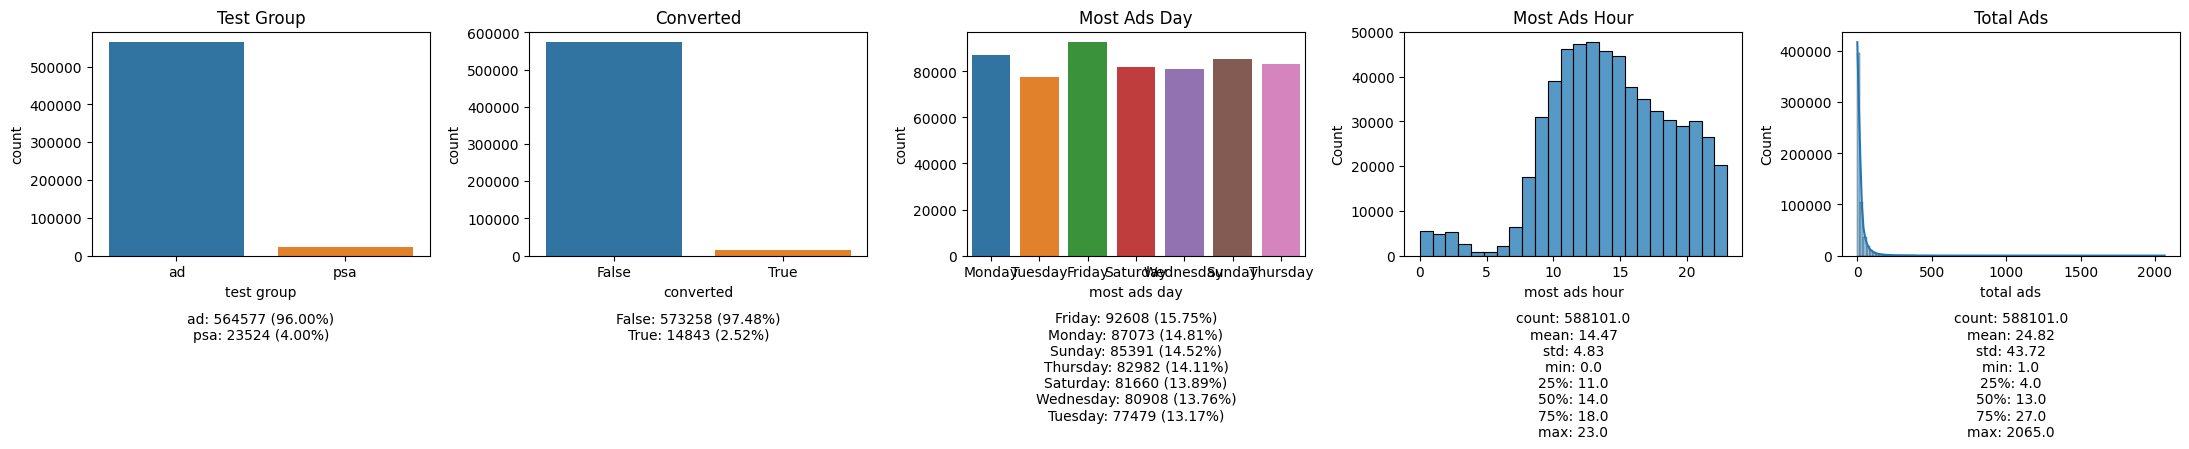

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = ["test group", "converted", "most ads day"]
num_cols = ["most ads hour", "total ads"]

fig, axes = plt.subplots(1, 5, figsize=(22, 5))

# 1. 범주형 변수
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(col.title())
    
    # 요약 텍스트 (count + 비율)
    counts = df[col].value_counts()
    props = df[col].value_counts(normalize=True)
    text = "\n".join([f"{idx}: {counts[idx]} ({props[idx]*100:.2f}%)" for idx in counts.index])
    
    axes[i].text(0.5, -0.25, text, ha="center", va="top", transform=axes[i].transAxes)

# 2. 연속형 변수
sns.histplot(df["most ads hour"], bins=24, ax=axes[3])
axes[3].set_title("Most Ads Hour")
stats_hour = df["most ads hour"].describe().round(2).astype(str)
text_hour = "\n".join([f"{idx}: {val}" for idx, val in stats_hour.items()])
axes[3].text(0.5, -0.25, text_hour, ha="center", va="top", transform=axes[3].transAxes)

sns.histplot(df["total ads"], bins=100, kde=True, ax=axes[4])
axes[4].set_title("Total Ads")
stats_total = df["total ads"].describe().round(2).astype(str)
text_total = "\n".join([f"{idx}: {val}" for idx, val in stats_total.items()])
axes[4].text(0.5, -0.25, text_total, ha="center", va="top", transform=axes[4].transAxes)

plt.tight_layout()
plt.show()

### 단변량 탐색 결과 요약

#### 1. Test Group
- **ad 그룹**: 564,577명 (96.0%)
- **psa 그룹**: 23,524명 (4.0%)  
→ A/B 테스트에서 광고 노출 그룹이 압도적으로 많음

#### 2. Converted
- **구매하지 않음 (False)**: 573,258명 (97.5%)
- **구매함 (True)**: 14,843명 (2.5%)  
→ 전체 전환율은 약 2.5%로 낮은 편

#### 3. Most Ads Day
- 가장 많은 비중은 **금요일 (15.8%)**
- 가장 적은 비중은 **화요일 (13.2%)**
→ 요일별로 차이는 있으나 큰 편은 아님

#### 4. Most Ads Hour
- 평균 노출 시간: **14.5시 (오후 2시 근처)**
- 중앙값: 14시  
- 분포: **정규 분포 형태에 가까우며**, 11 ~ 18시 구간 집중

#### 5. Total Ads
- 평균 광고 수: **24.8개**
- 중앙값: **13개**
- 분포: 극도로 **오른쪽 꼬리(long-tail)** → 일부 사용자는 매우 많은 광고를 봄 (최대 2,065개)  
→ 분포가 치우쳐 있으므로 분석 시 로그 변환 등 작업 필요

## 2. 이변량 탐색

  test group  converted
0         ad   0.025547
1        psa   0.017854


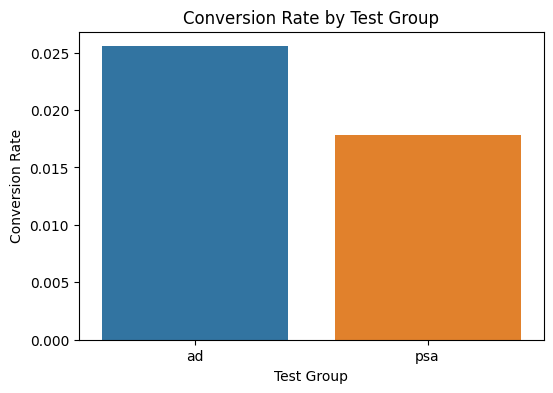

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# A/B 그룹별 전환율 계산
conversion_rate = df.groupby("test group")["converted"].mean().reset_index()

print(conversion_rate)

# 시각화
plt.figure(figsize=(6,4))
sns.barplot(x="test group", y="converted", data=conversion_rate)
plt.title("Conversion Rate by Test Group")
plt.ylabel("Conversion Rate")
plt.xlabel("Test Group")
plt.show()

most ads day
Monday       0.032812
Tuesday      0.029840
Wednesday    0.024942
Sunday       0.024476
Friday       0.022212
Thursday     0.021571
Saturday     0.021051
Name: converted, dtype: float64


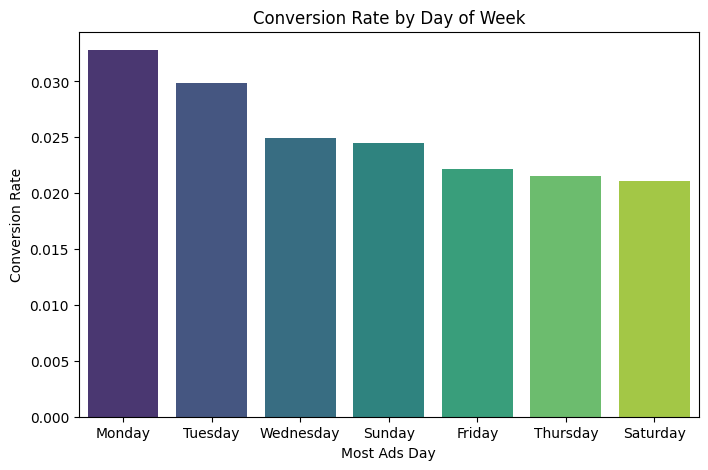

In [5]:
# 요일별 전환율 계산
day_conv = df.groupby("most ads day")["converted"].mean().sort_values(ascending=False)
print(day_conv)

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x=day_conv.index, y=day_conv.values, palette="viridis")
plt.ylabel("Conversion Rate")
plt.xlabel("Most Ads Day")
plt.title("Conversion Rate by Day of Week")
plt.show()

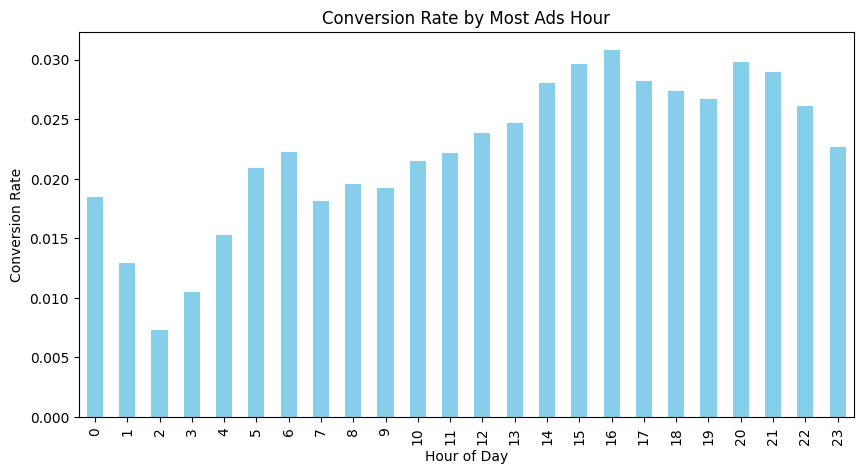

most ads hour
16    0.030772
20    0.029803
15    0.029653
21    0.028923
17    0.028210
Name: converted, dtype: float64

In [6]:
# 시간대별 전환율 계산
hourly_conversion = df.groupby('most ads hour')['converted'].mean()

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
hourly_conversion.plot(kind='bar', color='skyblue')
plt.title("Conversion Rate by Most Ads Hour")
plt.ylabel("Conversion Rate")
plt.xlabel("Hour of Day")
plt.show()

hourly_conversion.sort_values(ascending=False).head()

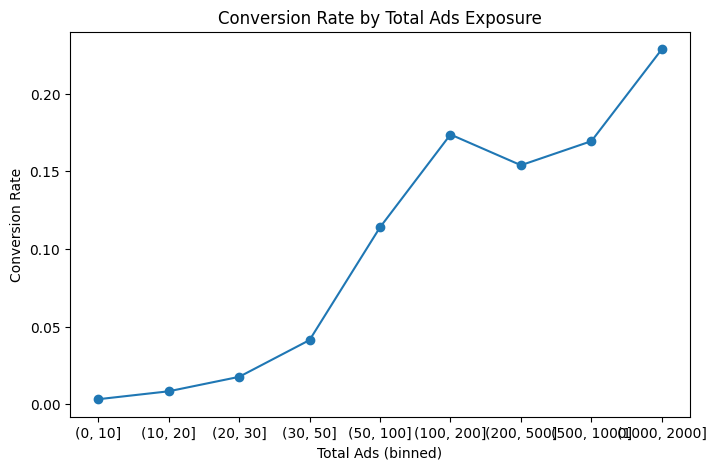

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# total ads를 구간으로 나누기
df['ads_bin'] = pd.cut(df['total ads'], bins=[0,10,20,30,50,100,200,500,1000,2000])

# 구간별 전환율 계산
ads_conv = df.groupby('ads_bin')['converted'].mean()

# 시각화
ads_conv.plot(kind='line', marker='o', figsize=(8,5))
plt.title("Conversion Rate by Total Ads Exposure")
plt.ylabel("Conversion Rate")
plt.xlabel("Total Ads (binned)")
plt.show()

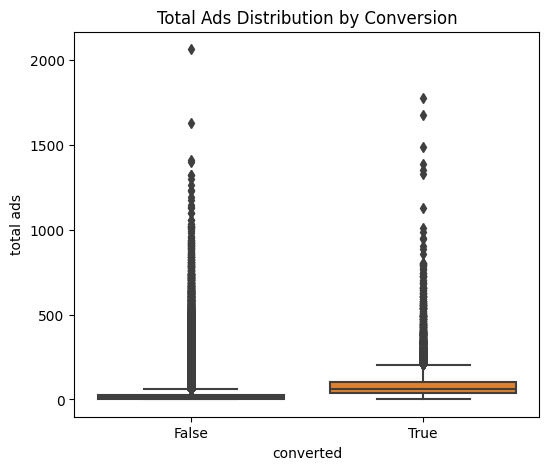

In [8]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.boxplot(x='converted', y='total ads', data=df)
plt.title("Total Ads Distribution by Conversion")
plt.show()

test group           ad       psa
most ads day                     
Friday        95.893443  4.106557
Monday        95.978087  4.021913
Saturday      96.500122  3.499878
Sunday        96.417655  3.582345
Thursday      95.294160  4.705840
Tuesday       96.248016  3.751984
Wednesday     95.686459  4.313541


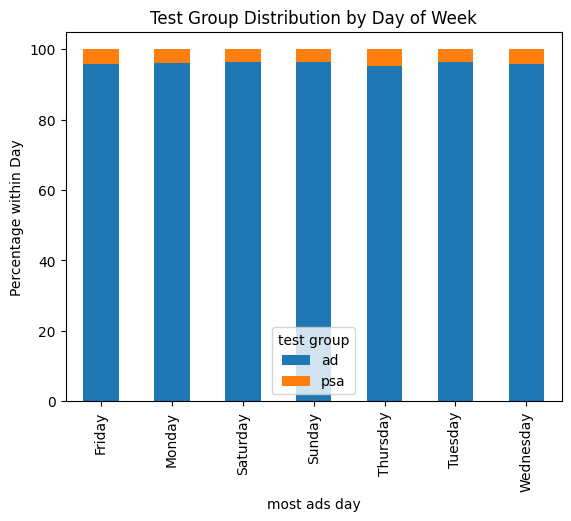

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 요일 × 그룹 교차표
ct = pd.crosstab(df['most ads day'], df['test group'], normalize='index') * 100
print(ct)

# 시각화
ct.plot(kind='bar', stacked=True)
plt.ylabel("Percentage within Day")
plt.title("Test Group Distribution by Day of Week")
plt.show()

### 이변량 탐색 결과 요약

#### 1. Test Group ↔ Converted (광고 효과)
- **광고 그룹(ad)** 의 전환율: **2.55%**
- **공익광고 그룹(psa)** 의 전환율: **1.78%**  
→ 광고 그룹의 전환율이 더 높아 **광고 효과가 존재**함을 시사

#### 2. Most Ads Day ↔ Converted (요일별 전환율 차이)
- 요일별 전환율 분포:
    - **월요일(3.28%)** > **화요일(2.98%)** > **수요일(2.49%)** ≒ **일요일(2.44%)**
    - 가장 낮은 요일은 **토요일(2.11%)**  
→ 주 초(월, 화)에 전환율이 상대적으로 높고, 주말로 갈수록 감소하는 경향

#### 3. Most Ads Hour ↔ Converted (시간대별 전환율 차이)
- 시간대별 전환율 Top 구간:
    - **16시(3.08%)**
    - **20시(2.98%)**
    - **15시(2.97%)**
    - **21시(2.89%)**
    - **17시(2.82%)**  
      → **오후 3시 ~ 5시, 저녁 8시 ~ 9시**에 전환율이 가장 높음
      
#### 4-1. Total Ads ↔ Converted (노출량과 전환율 관계)
- **노출량이 많은수록 전환율 증가**하는 추세 확인
- 단, (100 ~ 200회) 구간에서 잠시 감소 후 다시 증가  
→ 전반적으로 **광고 노출이 누적될수록 전환 가능성이 커짐**
      
#### 4-2. Total Ads ↔ Converted (Boxplot 분포)
- 전환 고객(True)의 광고 노출량 분포가 **비전환 고객(False)** 대비 확연히 높음
- 일부 극단치(outlier)는 존재하지만, 전환 그룹의 중앙값 자체가 더 큼    
→ **전환된 고객은 확실히 더 많은 광고를 본 경향**

#### 5. Test Group ↔ Most Ads Day (그룹 분배 랜덤성)
- 요일별 Test Group(ad vs psa) 분포 확인 결과
    - 요일별로 **ad 약 96%, psa 약 4%** 수준으로 유사하게 유지됨  
→ 그룹 배정은 요일에 따라 편향 없이 **랜덤하게 이루어짐**

## 3. 삼변량 탐색

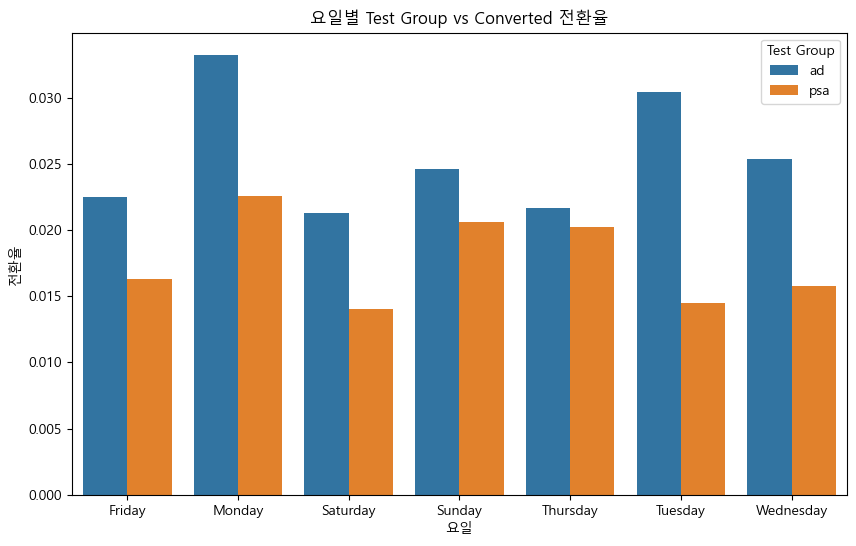

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# 한글 폰트 설정 (윈도우용)
plt.rc('font', family='Malgun Gothic')

# 마이너스 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False


# 요일별, 그룹별 전환율 계산
day_group = (
    df.groupby(['most ads day', 'test group'])['converted']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(data=day_group,
            x='most ads day',
            y='converted',
            hue='test group')

plt.title("요일별 Test Group vs Converted 전환율")
plt.ylabel("전환율")
plt.xlabel("요일")
plt.legend(title="Test Group")
plt.show()

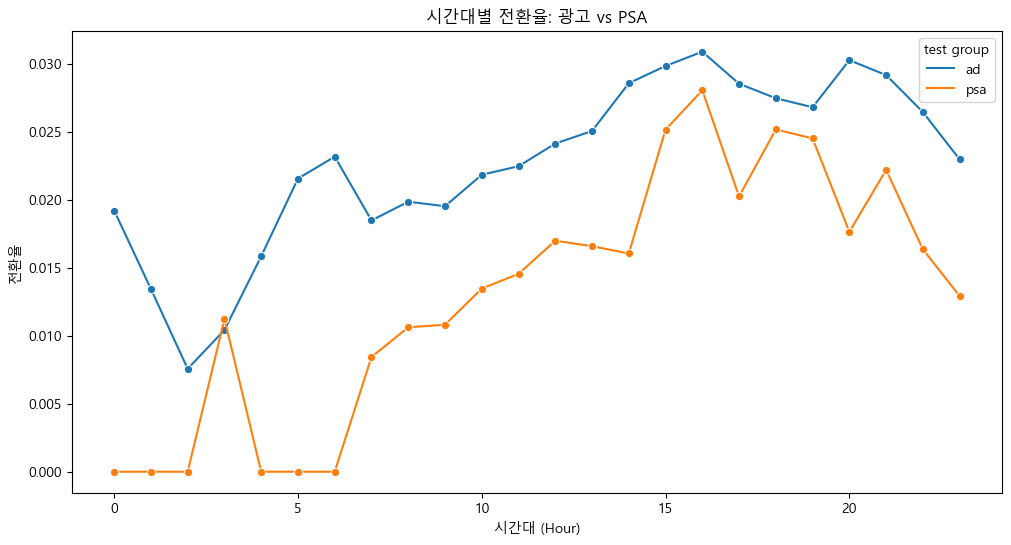

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시간대별, 그룹별 전환율 계산
conv_by_hour = df.groupby(['most ads hour', 'test group'])['converted'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(
    data=conv_by_hour,
    x='most ads hour',
    y='converted',
    hue='test group',
    marker='o'
)
plt.title('시간대별 전환율: 광고 vs PSA')
plt.ylabel('전환율')
plt.xlabel('시간대 (Hour)')
plt.show()

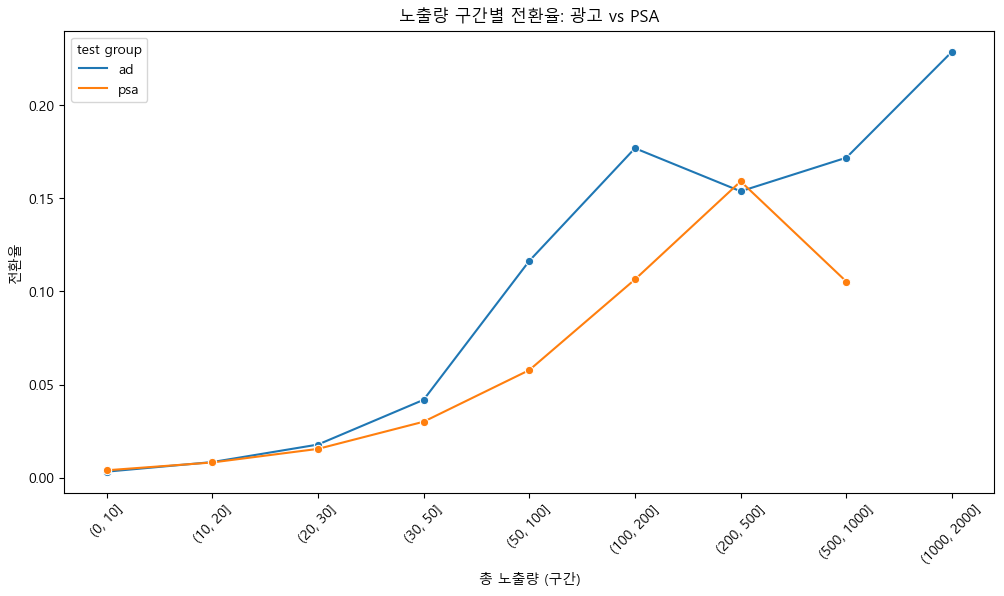

In [12]:
# total ads를 구간으로 나누기
bins = [0, 10, 20, 30, 50, 100, 200, 500, 1000, 2000]
labels = [f"({bins[i]}, {bins[i+1]}]" for i in range(len(bins)-1)]
df['ads_bin'] = pd.cut(df['total ads'], bins=bins, labels=labels, include_lowest=True)

# 그룹별 전환율 계산
ads_conversion = df.groupby(['ads_bin','test group'])['converted'].mean().reset_index()

# 시각화
plt.figure(figsize=(12,6))
sns.lineplot(
    data=ads_conversion,
    x='ads_bin',
    y='converted',
    hue='test group',
    marker='o'
)
plt.title("노출량 구간별 전환율: 광고 vs PSA")
plt.ylabel("전환율")
plt.xlabel("총 노출량 (구간)")
plt.xticks(rotation=45)
plt.show()

### 삼변량 탐색 결과 요약

#### 1. Test Group x Most Ads Day x Converted
- 광고 그룹(ad)이 항상 PSA 그룹보다 전환율이 높음
- 월요일, 화요일 전환율이 가장 높음
- 토요일 전환율이 가장 낮음

#### 2. Test Group x Most Ads Hour x Converted
- 전반적으로 광고 그룹(ad)이 PSA 그룹보다 전환율이 높음
- 11시 ~ 18시 구간에서 전환율이 상대적으로 높음
- PSA 그룹은 오후 15시 전후에 전환율이 소폭 상승
- 
#### 3. Test Group x Total Ads x Converted
- 노출량이 증가할수록 전환율이 상승하는 경향
- 일정 구간(200 ~ 500회)까지는 PSA와 ad 간 차이가 줄어듦
- 그 이상에서는 다시 광고 그룹(ad)이 우세